<a href="https://colab.research.google.com/github/KiptooAlvin/Alvin-project/blob/master/Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tweet Sentiment Analysis Notebook
This notebook guides you through loading, preprocessing, visualizing, and training multiple machine learning models for tweet sentiment classification. Each step includes explanations and comments for clarity.

## Step 1: Import Libraries
We import all necessary libraries for data manipulation, visualization, text processing, and model building.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import nltk
nltk.download('stopwords')  # Download stopwords for text cleaning

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Step 2: Load and Explore Data
Load the training and test datasets, view sample rows, and visualize the sentiment distribution.

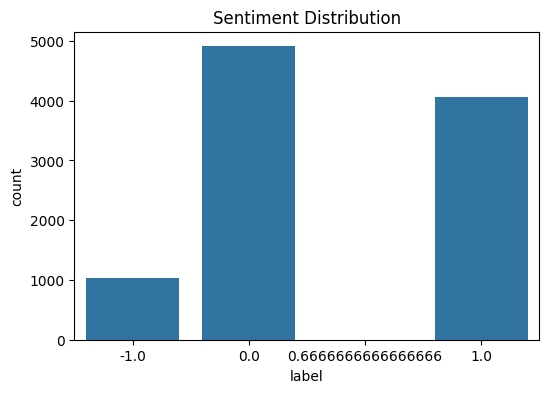

In [3]:
# Load datasets
train = pd.read_csv('/content/Train (1).csv')
test = pd.read_csv('/content/Test (1).csv')

# Preview first few rows
train.head()

# Visualize sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=train)
plt.title('Sentiment Distribution')
plt.show()

## Step 3: Clean and Prepare Data
We clean text by converting to lowercase, removing special characters and stopwords. This prepares the data for feature extraction.

In [4]:
stop_words = set(stopwords.words('english'))

# Function to clean text
def clean_text(text):
    # Convert non-string values to string
    if not isinstance(text, str):
        text = str(text)

    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    text = ' '.join(word for word in text.split() if word not in stop_words)  # Remove stopwords
    return text

# Apply cleaning function
train['clean_text'] = train['safe_text'].apply(clean_text)
test['clean_text'] = test['safe_text'].apply(clean_text)
train[['safe_text','clean_text']].head()

,safe_text,clean_text
0,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,amp big homie meanboy meanboy mb mbs mmr stegm...
1,I'm 100% thinking of devoting my career to pro...,im thinking devoting career proving autism isn...
2,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",whatcausesautism vaccines vaccinate child
3,I mean if they immunize my kid with something ...,mean immunize kid something wont secretly kill...
4,Thanks to <user> Catch me performing at La Nui...,thanks user catch performing la nuit nyc st av...


## Step 4: Convert Text to Numerical Features (TF-IDF)
Convert the cleaned text into numerical vectors using TF-IDF vectorization for machine learning models.

In [5]:
# Drop rows with NaN values in the 'label' column
train.dropna(subset=['label'], inplace=True)

# Convert label column to integer type
train['label'] = train['label'].astype(int)

vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 features
X_train = vectorizer.fit_transform(train['clean_text'])
X_test = vectorizer.transform(test['clean_text'])
y_train = train['label']

## Step 5: Logistic Regression

Logistic Regression is a simple yet powerful baseline model for text classification tasks.  
It works by estimating the probability that a given input belongs to a particular class using a logistic (sigmoid) function.  
We’ll train a Logistic Regression model to establish a baseline for sentiment prediction before comparing it with more comp


In [6]:
# Drop rows with NaN values in the 'label' column
train.dropna(subset=['label'], inplace=True)

# Re-assign y_train after dropping rows
y_train = train['label']

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_train)
print('Logistic Regression Classification Report:')
print(classification_report(y_train, y_pred_logreg))

# Save submission
submission_logreg = pd.DataFrame({
    'tweet_id': test['tweet_id'],
    'sentiment': logreg.predict(X_test)
})
submission_logreg.to_csv('/content/submission_logreg.csv', index=False)

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          -1       0.88      0.38      0.53      1038
           0       0.85      0.89      0.87      4909
           1       0.79      0.87      0.82      4053

    accuracy                           0.82     10000
   macro avg       0.84      0.71      0.74     10000
weighted avg       0.83      0.82      0.82     10000



 ## Step 6: Random Forest Classifier

The Random Forest algorithm is an ensemble method that combines multiple decision trees to improve prediction accuracy and reduce overfitting.  
Each tree is trained on a random subset of the data and features, and their results are averaged for the final prediction.  
We’ll train a Random Forest Classifier to evaluate its ability to capture complex sentiment patterns in the text data.


In [7]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_train)
print('Random Forest Classification Report:')
print(classification_report(y_train, y_pred_rf))

submission_rf = pd.DataFrame({
    'tweet_id': test['tweet_id'],
    'sentiment': rf.predict(X_test)
})
submission_rf.to_csv('/content/submission_rf.csv', index=False)

Random Forest Classification Report:
              precision    recall  f1-score   support

          -1       1.00      0.99      0.99      1038
           0       0.99      1.00      0.99      4909
           1       0.99      0.99      0.99      4053

    accuracy                           0.99     10000
   macro avg       1.00      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## XGBoost Classifier

XGBoost (Extreme Gradient Boosting) is an efficient and scalable implementation of gradient boosting algorithms.  
It builds an ensemble of weak learners (decision trees) in sequence, where each new tree corrects the errors of the previous ones.  
This model is known for its high performance and is widely used in text classification tasks such as sentiment analysis.


In [9]:
# Map labels -1, 0, 1 to 0, 1, 2 for XGBoost
label_mapping = {-1: 0, 0: 1, 1: 2}
y_train_mapped = y_train.map(label_mapping)

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train_mapped) # Use the mapped labels for training
y_pred_xgb_mapped = xgb.predict(X_train)

# Map predictions back to original labels for evaluation and submission
inverse_label_mapping = {0: -1, 1: 0, 2: 1}
y_pred_xgb = pd.Series(y_pred_xgb_mapped).map(inverse_label_mapping)

print('XGBoost Classification Report:')
print(classification_report(y_train, y_pred_xgb))

submission_xgb = pd.DataFrame({
    'tweet_id': test['tweet_id'],
    'sentiment': xgb.predict(X_test)
})
# Map the predicted sentiment in the submission back to the original labels
submission_xgb['sentiment'] = submission_xgb['sentiment'].map(inverse_label_mapping)
submission_xgb.to_csv('/content/submission_xgb.csv', index=False)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:01:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Classification Report:
              precision    recall  f1-score   support

          -1       0.97      0.51      0.67      1038
           0       0.88      0.91      0.89      4909
           1       0.81      0.88      0.85      4053

    accuracy                           0.86     10000
   macro avg       0.89      0.77      0.80     10000
weighted avg       0.86      0.86      0.85     10000



##  Support Vector Machine (SVM) Model

The Support Vector Machine (SVM) is a powerful classification algorithm that works by finding the optimal hyperplane that separates different sentiment classes.  
It is especially effective in high-dimensional spaces, such as text data represented by TF-IDF features.  
We’ll train an SVM classifier and generate predictions for the test dataset.


In [11]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_train)
print(classification_report(y_train, y_pred_svm))
submission_svm = pd.DataFrame({'ID': test['tweet_id'], 'target': svm.predict(X_test)})
submission_svm.to_csv('/content/submission_svm.csv', index=False)

              precision    recall  f1-score   support

          -1       0.98      0.69      0.81      1038
           0       0.95      0.95      0.95      4909
           1       0.90      0.96      0.93      4053

    accuracy                           0.93     10000
   macro avg       0.94      0.87      0.90     10000
weighted avg       0.93      0.93      0.93     10000



## Gradient Boosting Classifier

Gradient Boosting is an ensemble learning method that builds models sequentially, where each new model tries to correct the errors made by the previous ones.  
It combines multiple weak learners (usually decision trees) to create a strong predictive model.  
We’ll train a Gradient Boosting Classifier and evaluate its performance on the sentiment data.


In [12]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_train)
print(classification_report(y_train, y_pred_gb))
submission_gb = pd.DataFrame({'ID': test['tweet_id'], 'target': gb.predict(X_test)})
submission_gb.to_csv('/content/submission_gb.csv', index=False)

              precision    recall  f1-score   support

          -1       0.90      0.21      0.34      1038
           0       0.78      0.85      0.82      4909
           1       0.71      0.77      0.74      4053

    accuracy                           0.75     10000
   macro avg       0.80      0.61      0.63     10000
weighted avg       0.77      0.75      0.74     10000



 ## Perform Cross-Validation
We will use Stratified K-Fold cross-validation to evaluate the performance of the models more robustly. Stratified K-Fold ensures that each fold has the same proportion of observations with a given label as the entire dataset, which is important for imbalanced datasets.

In [14]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the models to evaluate
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier()
}

# Initialize Stratified K-Fold
n_splits = 5  # You can change the number of splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    results[name] = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }
    print(f"Performing cross-validation for {name}...")

    # For XGBoost, use the mapped labels
    y_train_cv = y_train_mapped if name == 'XGBoost' else y_train

    for fold, (train_index, val_index) in enumerate(skf.split(X_train, y_train_cv)):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train_cv.iloc[train_index], y_train_cv.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)

        # If the model is XGBoost, map predictions back to original labels for evaluation
        if name == 'XGBoost':
            y_pred_fold = pd.Series(y_pred_fold).map(inverse_label_mapping)
            y_val_fold = pd.Series(y_val_fold).map(inverse_label_mapping)


        results[name]['accuracy'].append(accuracy_score(y_val_fold, y_pred_fold))
        results[name]['precision'].append(precision_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0))
        results[name]['recall'].append(recall_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0))
        results[name]['f1_score'].append(f1_score(y_val_fold, y_pred_fold, average='weighted', zero_division=0))

# Calculate and display average results
print("\nCross-Validation Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
    print(f"  Average Precision: {np.mean(metrics['precision']):.4f}")
    print(f"  Average Recall: {np.mean(metrics['recall']):.4f}")
    print(f"  Average F1-Score: {np.mean(metrics['f1_score']):.4f}")

Performing cross-validation for Logistic Regression...
Performing cross-validation for Random Forest...
Performing cross-validation for XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:21:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:21:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:21:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:21:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:21:55] WARNING: /w

Performing cross-validation for SVM...
Performing cross-validation for Gradient Boosting...

Cross-Validation Results:

Logistic Regression:
  Average Accuracy: 0.7277
  Average Precision: 0.7235
  Average Recall: 0.7277
  Average F1-Score: 0.7105

Random Forest:
  Average Accuracy: 0.7269
  Average Precision: 0.7324
  Average Recall: 0.7269
  Average F1-Score: 0.7045

XGBoost:
  Average Accuracy: 0.7236
  Average Precision: 0.7142
  Average Recall: 0.7236
  Average F1-Score: 0.7075

SVM:
  Average Accuracy: 0.7319
  Average Precision: 0.7386
  Average Recall: 0.7319
  Average F1-Score: 0.7100

Gradient Boosting:
  Average Accuracy: 0.7171
  Average Precision: 0.7159
  Average Recall: 0.7171
  Average F1-Score: 0.6952
